# Calculate 𝜋
A Monte-Carlo simulation, an embarrassingly parallel algorithm. Caluclations wil lbe performed sequentially and in parallel (distributed) with Ray.



Text(0.2, 0.3, '$\\pi/4$')

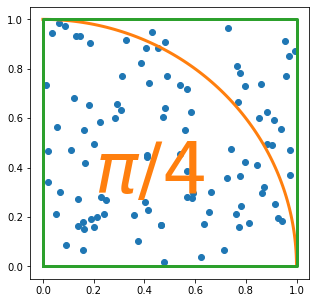

In [54]:
# illustration of the solution procedure
import numpy as np
import matplotlib.pyplot as plt
samples = np.random.rand(2, 100)
plt.figure(figsize=[5,5])
plt.plot(samples[0,:], samples[1,:], 'o', np.sin(np.linspace(0,np.pi/2,100)), np.cos(np.linspace(0,np.pi/2,100)), '-', [0, 0, 1, 1, 0], [0, 1, 1, 0, 0], '-', linewidth=3)
plt.text(0.2, 0.3, '$\pi/4$', fontsize=72, color=u'#ff7f0e')


In [ ]:
# import modules, initialize Ray

import numpy as np
import pickle
import ray
import math

if ray.is_initialized():
    ray.shutdown()

ray.init()

In [ ]:
# Basic procedures for calculating pi

def takeSamples(num):
    bufferSize = 10000 if num > 10000 else 10
    takenSamples = 0
    countInside = 0
    while num > takenSamples:
        samples = np.random.rand(2, bufferSize)
        #countInside += np.sum(np.hypot(samples[0], samples[1]) <= 1)
        #countInside += np.sum(samples[0]*samples[0]+samples[1]*samples[1] <= 1)
        countInside += np.sum(np.square(samples).sum(0) <= 1)
        takenSamples += bufferSize
    return countInside, takenSamples

def printPi(numSamples, alg):
    inside, total = alg(numSamples)
    pi = inside/total * 4
    print(f"𝜋 ({numSamples} samples) = {pi:.13f}")

def getPi(numSamples, alg):
    inside, total = alg(numSamples)
    pi = inside/total * 4
    return pi

printPi(100, takeSamples)
printPi(1000, takeSamples)
printPi(10000, takeSamples)
printPi(100000, takeSamples)
printPi(1000000, takeSamples)
printPi(10000000, takeSamples)
printPi(100000000, takeSamples)
print('---------------------------------------')

In [ ]:
for ext in range(2, 9):
    samples = 10**ext
    print(f"{samples}:")
    %timeit -r1 getPi(samples, takeSamples)
#%timeit -r10 -n1  getPi(10000000, takeSamples)
print('------------------------------------------------------------')

In [ ]:
@ray.remote
def raySamples(numSamples):
    return takeSamples(numSamples)

def takeSamplesParallel(numSamples):
    numProcesses = 4
    n = math.ceil(numSamples/numProcesses)
    futures = [raySamples.remote(n) for i in range(numProcesses)]
    results = ray.get(futures)
    total = np.sum((r[1] for r in results))
    inside = np.sum((r[0] for r in results))
    return inside, total


In [ ]:
for ext in range(2, 9):
    samples = 10**ext
    print(f"{samples}:")
    %timeit -r1 getPi(samples, takeSamplesParallel)
#%timeit -r10 -n1  getPi(10000000, takeSamples)
print('------------------------------------------------------------')

## Execution time and speedup analysis

In [ ]:
t_s = []
t_p = []
n = []
for ext in range(10, 25):
    samples = 2**ext
    n.append(samples)
    t = %timeit -o -r3 getPi(samples, takeSamples)
    t_s.append(t)
    t = %timeit -o -r3 getPi(samples, takeSamplesParallel)
    t_p.append(t)
print("done")

In [ ]:
import matplotlib as mat
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[15, 6])
plt.subplot(1,2,1)
plt.grid('on')
plt.loglog(n, [t.average for t in t_s], '--', linewidth=5)
plt.loglog(n, [t.average for t in t_p], '-', linewidth=5)
plt.legend(['sequential', 'parallel'])
plt.ylabel('time [s]')
plt.xlabel('num samples')

plt.subplot(1,2,2)
plt.grid('on')
s = [t_s[i].average/t_p[i].average for i in range(len(t_p))]
plt.semilogx(n, s, '-', linewidth=5)
plt.legend('speedup')
plt.ylabel('time [s]')
plt.xlabel('num samples')